In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pycountry
pd.set_option('display.max_columns', 500)

In [2]:
stack_overflow_files = (os.listdir("data/"))
# not worth going from 2011-2014. No data scientists.
# ok, so decision to do (2019 maybe) 2020-2023 for analysis

# GPT gave me this idea instead of going through every possible country manually
country_abbreviations_1 = {country.name: country.alpha_2 for country in pycountry.countries}
country_abbreviations_2 = {country.name: country.official_name for country in pycountry.countries}

C:\Users\luism\anaconda3\envs\milestone_1\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [3]:
def read_stackoverflow_csvs() -> dict:
    """
    Reads CSVs and gets the numbe of data professionals. Any empty values are dropped from job title and 
    salary so we will always have data. Other columns may have nans.
    Data Manipulation:
    - dropping nans from salary and devtype combined
    - Changing the salary column to ConvertedCompYearly so we can merge all data frames comes time
    - Converting specific columns that mean the same thing per year into a singular name
    """
    frames = {}
    stack_o_files = os.listdir("data/")
    for file in stack_o_files[1:]:
        year = file[-8:-4]
        df = pd.read_csv(f"data/{file}", encoding='ISO-8859-1')

        # standardize compensation columns
        if 'ConvertedComp' in df.columns:
            df = df.rename(columns={'ConvertedComp': 'ConvertedCompYearly'})

        # standardize some columns
        standard = ["Language", "Database", "Platform", "WebFrame", "MiscTech"]
        for stan in standard:
            if f"{stan}WorkedWith" in df.columns:
                df = df.rename(columns={f'{stan}WorkedWith': f'{stan}HaveWorkedWith', f'{stan}DesireNextYear':f'{stan}WantToWorkWith'})

        # standardize some country names, now they should match with Kaggle dataset
        df["Country"] = df["Country"].replace(country_abbreviations_1)
        df["Country"] = df["Country"].replace(country_abbreviations_2)
        
        
        df = df.dropna(subset=["DevType", "ConvertedCompYearly"])
        df = df[df["DevType"].str.contains("data", case=False)]
        df["Year"] = [year] * len(df)
        frames[f"df_data_{year}"] = df
    return frames

In [4]:
frames_dict = read_stackoverflow_csvs()

In [5]:
# this is the number of entries we are working with in our frames
# seeing how to standardize the columns some more

query = "Remote"
for key, frame in frames_dict.items():
    lang = []
    for col in frame.columns:
        lang.append(col) if query in col else None
    print(f"{key}\t{len(frame)}\t{lang}")

df_data_2019	13393	['WorkRemote']
df_data_2020	8294	[]
df_data_2021	9272	[]
df_data_2022	6921	['RemoteWork']
df_data_2023	2480	['RemoteWork']


In [6]:
# print(frames_dict["df_data_2019"].columns)

In [7]:
# print(frames_dict["df_data_2020"].columns)

In [8]:
# print(frames_dict["df_data_2021"].columns)

In [9]:
# print(frames_dict["df_data_2022"].columns)

In [10]:
# print(frames_dict["df_data_2023"].columns)

In [11]:
# do they have similar columns?
def find_similar_col(frames) -> set:
    """
    Returns the set of columns that the all share, ideally we maximize the ratio of this to merge.
    """
    union = []
    for key, frame in frames.items():
        union.append(set(frame.columns))
        
    standard = union[0]
    for cols in union[1:]:
        standard = standard.intersection(cols)
    return standard

In [12]:
find_similar_col(frames_dict)

{'Age',
 'CompTotal',
 'ConvertedCompYearly',
 'Country',
 'DatabaseHaveWorkedWith',
 'DatabaseWantToWorkWith',
 'DevType',
 'EdLevel',
 'Employment',
 'LanguageHaveWorkedWith',
 'LanguageWantToWorkWith',
 'MainBranch',
 'MiscTechHaveWorkedWith',
 'MiscTechWantToWorkWith',
 'OrgSize',
 'PlatformHaveWorkedWith',
 'PlatformWantToWorkWith',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Year',
 'YearsCode',
 'YearsCodePro'}

In [13]:
# play around with the number and see if this is the spread that we want
for key, frame in frames_dict.items():
    grouped = (frame.groupby("Country").count())
    grouped = grouped[grouped["MainBranch"] > 10]
    length = len(grouped)
    print(f"""{key}: {length}
    max: {grouped['MainBranch'].idxmax()}, {grouped['MainBranch'].max()}
    min: {grouped['MainBranch'].idxmin()}, {grouped['MainBranch'].min()}""")

df_data_2019: 83
    max: US, 3856
    min: AM, 11
df_data_2020: 69
    max: US, 2081
    min: BY, 11
df_data_2021: 70
    max: United States of America, 2144
    min: BA, 11
df_data_2022: 63
    max: United States of America, 1702
    min: EG, 11
df_data_2023: 36
    max: United States of America, 687
    min: CN, 11


In [14]:
# do they have similar columns?
def find_similar_country(frames: dict, cull_factor=20) -> set:
    """
    Given a particular minimum (cull_factor) find the countries in common among
    frames.
    """
    union = []
    for key, frame in frames.items():
        grouped = frame.groupby("Country").count()
        grouped = grouped[grouped["MainBranch"] > cull_factor]
        union.append(set(grouped.index))
        
    standard = union[0]
    for cols in union[1:]:
        standard = standard.intersection(cols)
    return standard

def show_country_dist(frames: dict, countries: list, cull_factor: int) -> None:
    """
    Just plot a bar chart for our country distributions using the above function.
    """
    rows = len(frames)//2 + 1
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15,15))
    fig.suptitle(f"{len(countries)} respondents consistent across surveys greater than {cull_factor} responses")
    for (key, frame), ax in zip(frames.items(), axes.reshape(-1)):
        grouped = frame.groupby("Country").count()
        grouped = grouped.loc[list(countries)].sort_values("MainBranch")
        grouped.plot(y="MainBranch", ax=ax, kind="bar", legend=False)
        ax.set_title(key[-4:])
    
    plt.show()

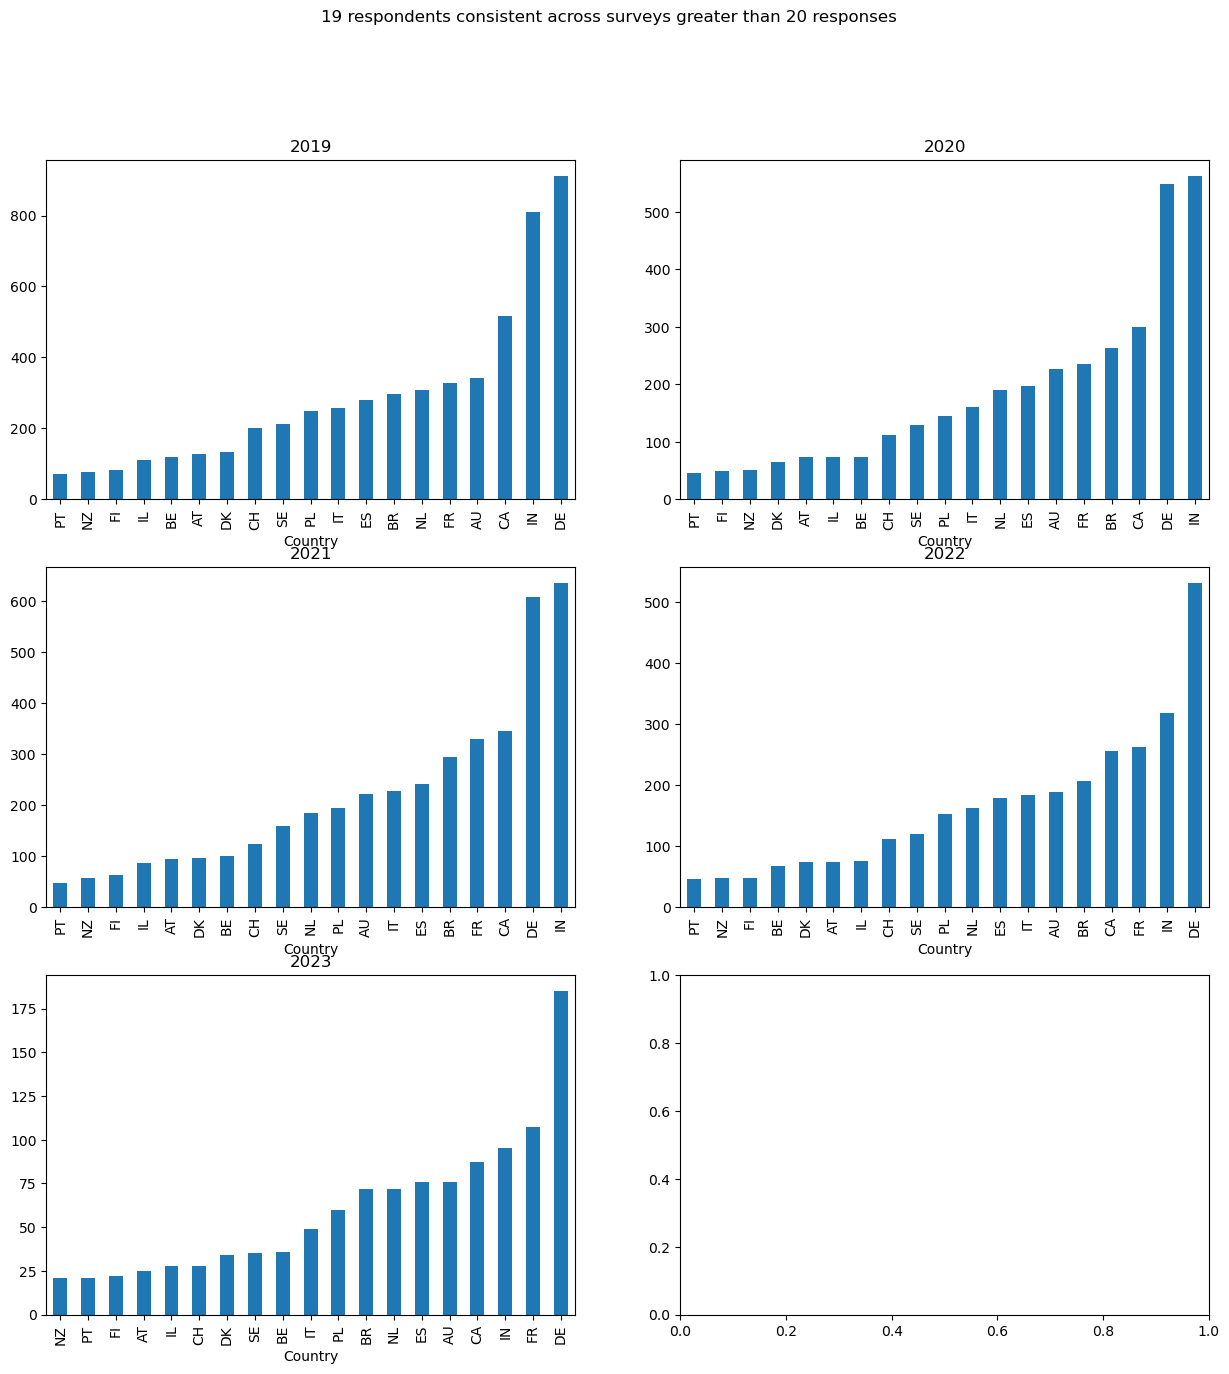

In [15]:
# across all data sets here are the countries that are here most often
# where is US? UK? They have different, inconsistent names throughout the years
# # i.e. United States vs United States of America; UK vs United Kingdom, see above mapping
cull_factor = 20
country_sim = find_similar_country(frames_dict, cull_factor)
show_country_dist(frames_dict, list(country_sim), cull_factor)